In [167]:
import numpy as np
import math
import matplotlib.pyplot as plt
from random import choices
from random import sample
from scipy.special import comb
from scipy.stats import norm
from scipy import stats
import scipy.integrate as integrate
import warnings
warnings.filterwarnings('ignore')

# 1. RO-Payment Function VS Linear Payment Function

## 1.1. Without adding noise

The $f$-pairing mechanism

Text(0, 0.5, 'Total Payment')

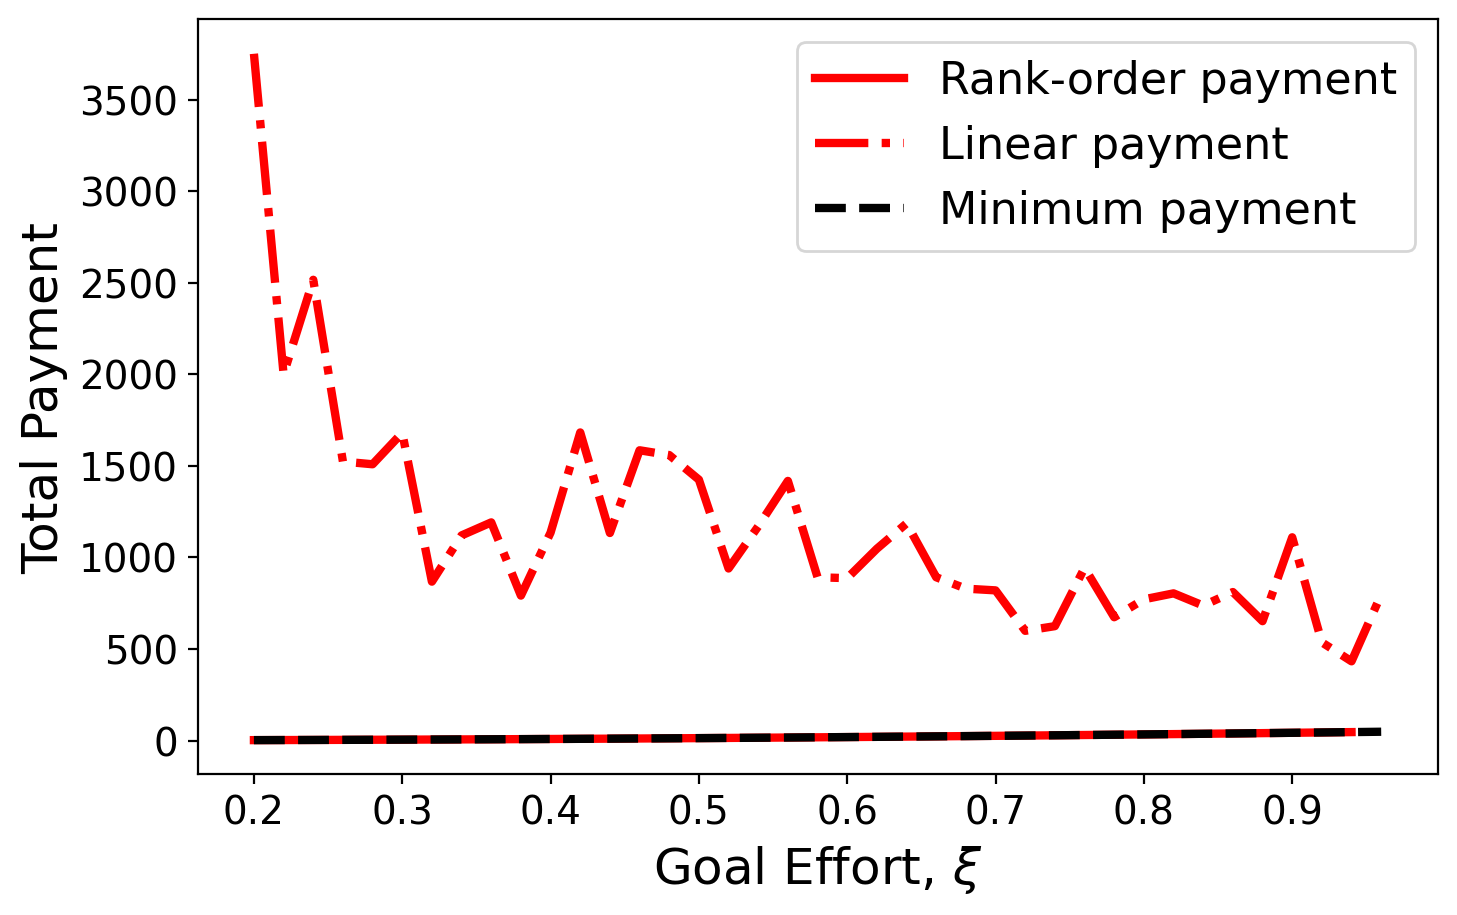

In [320]:
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
Effort_list = np.arange(0.2,0.95,0.02) # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.
Mechanisms = ['tvd', 'kl', 'sqr', 'hlg']

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)

########## Loading the estimated mean and std
"""
Choose the f function: 1 -> TVD, 2 -> KL, 3 -> Sqr, 4 -> Hlg
"""
f = 1
mean_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean.npy')
std_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance.npy')
mean_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_deviate.npy')
std_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance_deviate.npy')

########## Compute (and smoothen) the probability of ranking after deviation
p_i = np.zeros(len(Effort_list))
for i in range(len(Effort_list)):
    p_i[i] = prob_i(mean_1[i+10], mean_2[i+10], np.square(std_1[i+10]), std_2[i+10], 1)
para = np.polyfit(Effort_list, p_i, 3)
p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'red',linewidth = 3,label='Rank-order payment')

    

    
########## Compute the payment of the optimal linear payment function
Effort_list = np.arange(0,0.97,0.02)
c = cost(Effort_list)*n
dc = np.zeros(len(Effort_list))
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)
    
sample = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_samples.npy')
mean_1 = np.average(sample[0], axis = 1)
mean_2 = np.average(sample[1], axis = 1)
para = np.polyfit(Effort_list, mean_2-mean_1, 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[0].T, axis = 0)
payment = (np.average(sample[0], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(Effort_list[index_IR])*n
plt.plot(Effort_list[10:],payment[10:],color = 'red',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list[10:],c[10:],color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)


The $f$-matrix mechanism

Text(0, 0.5, 'Total Payment')

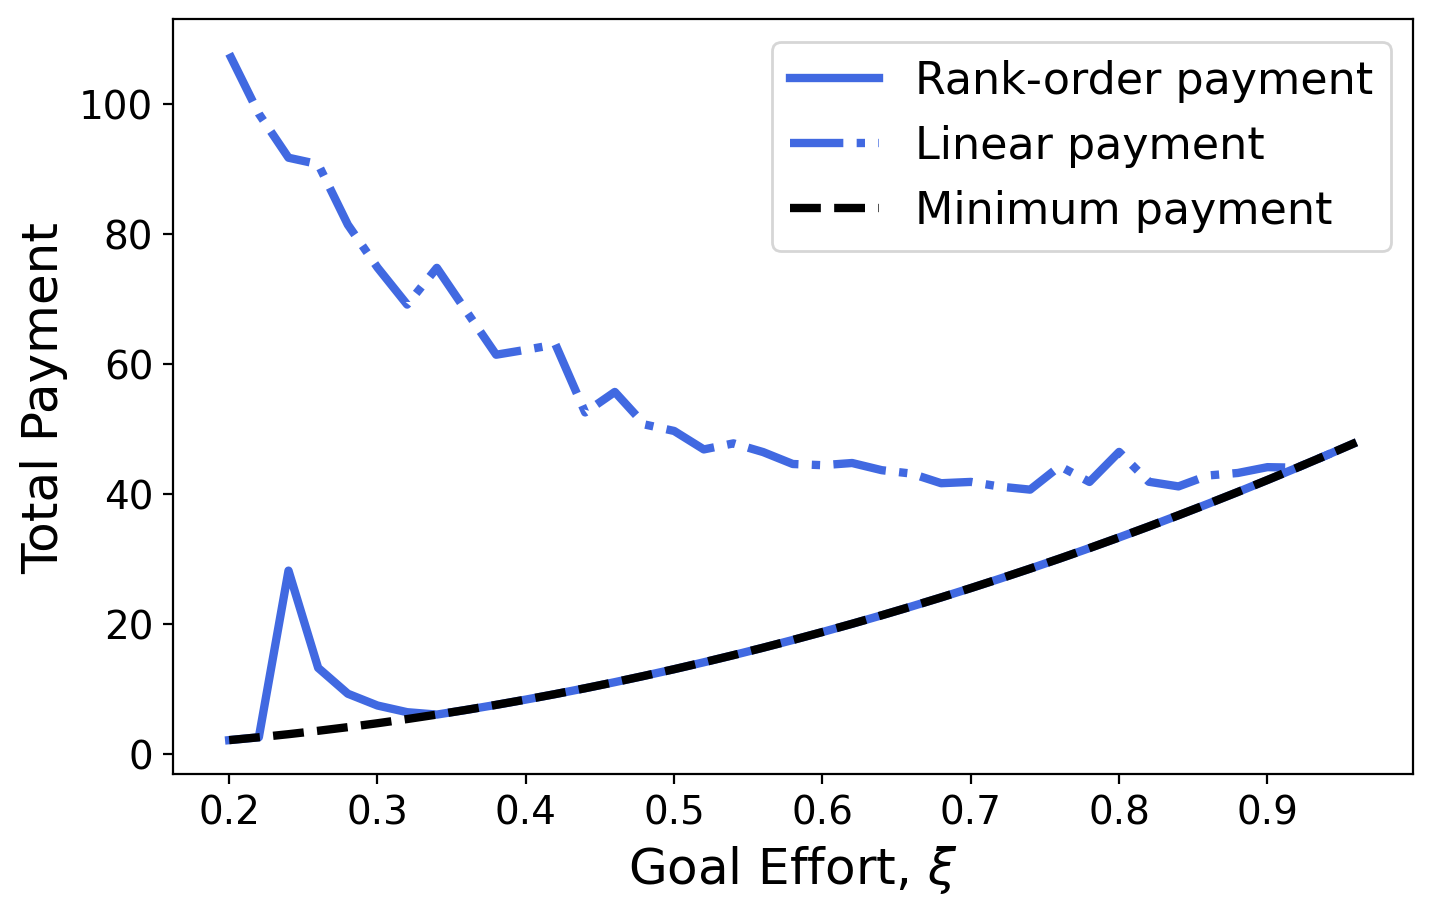

In [321]:
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
Effort_list = np.arange(0.2,0.95,0.02) # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)

########## Loading the estimated mean and std
"""
Choose the f function: 1 -> TVD, 2 -> KL, 3 -> Sqr, 4 -> Hlg
"""
f = 1
mean_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean.npy')
std_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance.npy')
mean_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_deviate.npy')
std_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance_deviate.npy')

########## Compute (and smoothen) the probability of ranking after deviation
p_i = np.zeros(len(Effort_list))
for i in range(len(Effort_list)):
    p_i[i] = prob_i(mean_1[i+10], mean_2[i+10], std_1[i+10], std_2[i+10], 1)
para = np.polyfit(Effort_list, p_i, 3)
p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'royalblue',linewidth = 3,label='Rank-order payment')

    

    
########## Compute the payment of the optimal linear payment function
Effort_list = np.arange(0,0.97,0.02)
c = cost(Effort_list)*n
dc = np.zeros(len(Effort_list))
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)
    
sample = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_samples.npy')
mean_1 = np.average(sample[0], axis = 1)
mean_2 = np.average(sample[1], axis = 1)
para = np.polyfit(Effort_list, mean_2-mean_1, 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[0].T, axis = 0)
payment = (np.average(sample[0], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(Effort_list[index_IR])*n
plt.plot(Effort_list[10:],payment[10:],color = 'royalblue',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list[10:],c[10:],color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)


Spot-checking with accuracy score

Text(0, 0.5, 'Total Payment')

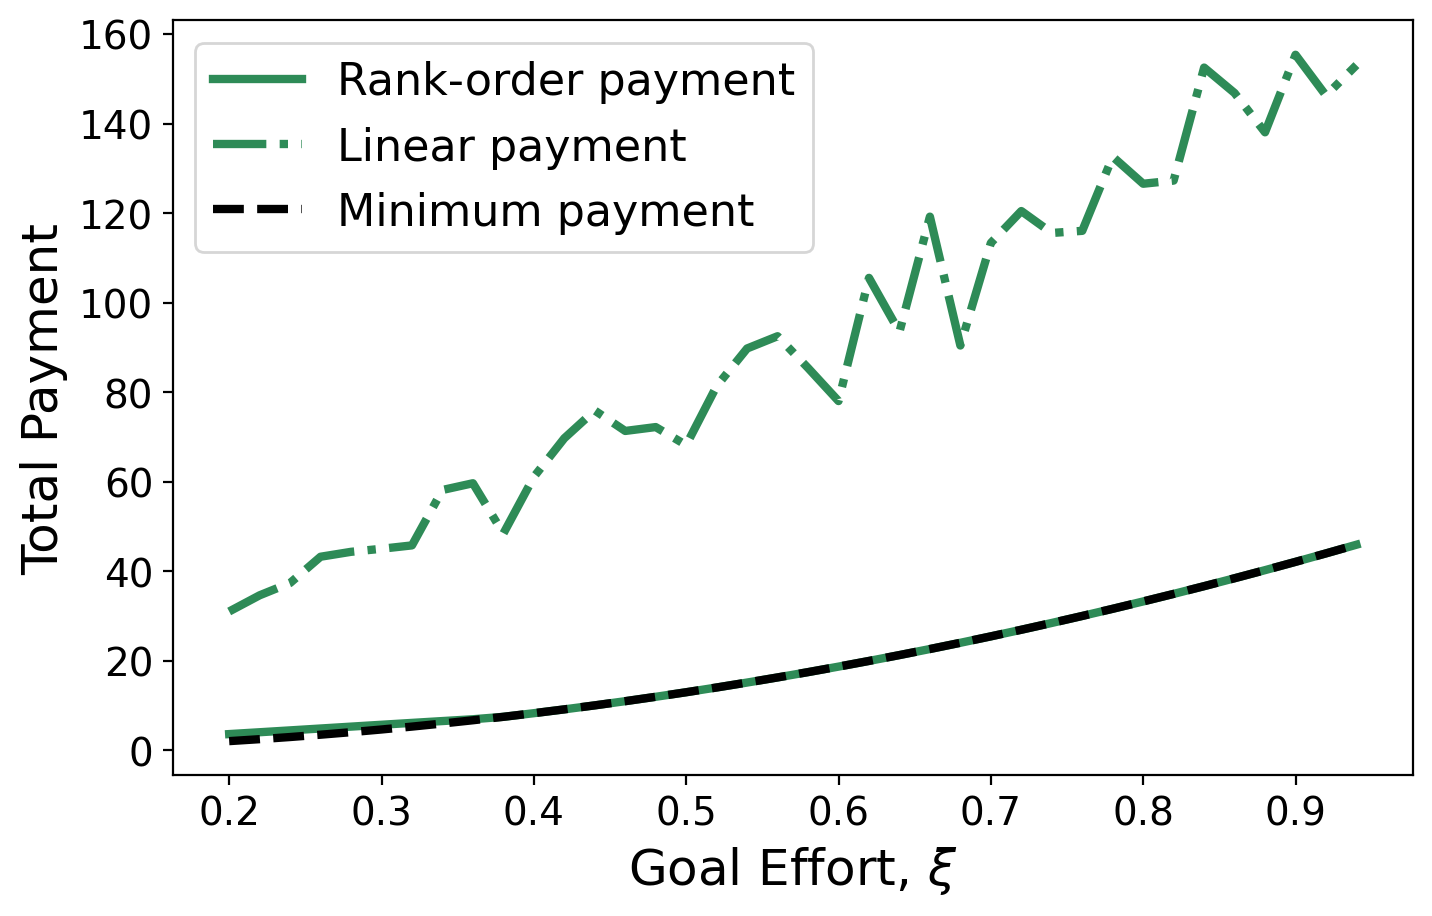

In [174]:
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
check_prob = 0.2
Effort_list = np.arange(0.2,0.95,0.02) # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)

########## Loading the samples
sample = np.load('Samples/Effort_equilibrium/W1/Spot_check_Acc/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_check_p_'+str(check_prob)+'_samples.npy')

########## Compute (and smoothen) the probability of ranking after deviation
mean = np.average(sample, axis = 1)
std = np.std(sample, axis = 1)

p_i = np.zeros(len(Effort_list))
for i in range(len(Effort_list)):
    p_i[i] = prob_i(mean[i+10], mean[i+12], std[i+10], std[i+12], 1)
    
para = np.polyfit(Effort_list, p_i, 3)
p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'seagreen',linewidth = 3,label='Rank-order payment')

    

    
########## Compute the payment of the optimal linear payment function
    
para = np.polyfit(Effort_list, mean[12:50]-mean[10:48], 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[10:48].T, axis = 0)
payment = (np.average(sample[10:48], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(Effort_list[index_IR])*n
plt.plot(Effort_list,payment,color = 'seagreen',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list,c,color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)


## 1.2. Adding noise

In [217]:
def find_minimum_shock_WTA(mu_1, mu_2, sig_1, sig_2):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral untruthful deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral untruthful deviation.
    Output: the minimum common shock that makes the untruthful strategy unpreferred.
    """
    if mu_2 >= mu_1-1e-3: # deviation brings a larger mean (with a small error)
        return -1

    p1 = prob_i(mu_1, mu_2, sig_1, sig_2, 1)
    if p1 <= 1/n:
        return 0
    high = 10*sig_1
    p1_high = prob_i(mu_1, mu_2, np.sqrt(np.square(sig_1)+np.square(high)), np.sqrt(np.square(sig_2)+np.square(high)), 1)
    while p1_high >= 1/n:
        high *= 10
        p1_high = prob_i(mu_1, mu_2, np.sqrt(np.square(sig_1)+np.square(high)), np.sqrt(np.square(sig_2)+np.square(high)), 1)
    
    low = 0
    while high-low > 1e-3*sig_1:
        mid = (low+high)/2
        p1 = prob_i(mu_1, mu_2, np.sqrt(np.square(sig_1)+np.square(mid)), np.sqrt(np.square(sig_2)+np.square(mid)), 1)
        if p1 > 1/n:
            low = mid
        else:
            high = mid
    return high

The $f$-pairing mechanism

In [313]:
"""
Compute the common shock
"""
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 3000 # the number of times the simulation is run
check_prob = 0.2

########## Loading the samples
Mechanisms = ['tvd', 'kl', 'sqr', 'hlg']
f = 3
mean_t = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_larger.npy')
mean_u = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_deviate_larger.npy')
std_t = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_std_larger.npy')
std_u = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_std_deviate_larger.npy')
########## Compute the common shock (winner-take-all)
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

common_shock = np.zeros(8)
for i,e in enumerate(Effort_list): # for each effort
    shock_strategy = []
    for s in range(7): # for each untruthful strategy
        shock_strategy.append(find_minimum_shock_WTA(mean_t[i], mean_u[i,s], std_t[i], std_u[i,s]))
    common_shock[i] = np.max(shock_strategy)
    
print('The minimum common shock for each effort: \n', common_shock)
print('The standard deviation of the original performance score: \n',  std_t)

The minimum common shock for each effort: 
 [0.30233046 0.22914566 0.29687657 0.20974861 0.20142596 0.23103409
 0.15697241 0.40571706]
The standard deviation of the original performance score: 
 [0.08881804 0.10000859 0.10535035 0.12564977 0.13877893 0.16329864
 0.177368   0.19402418]


Text(0, 0.5, 'Total Payment')

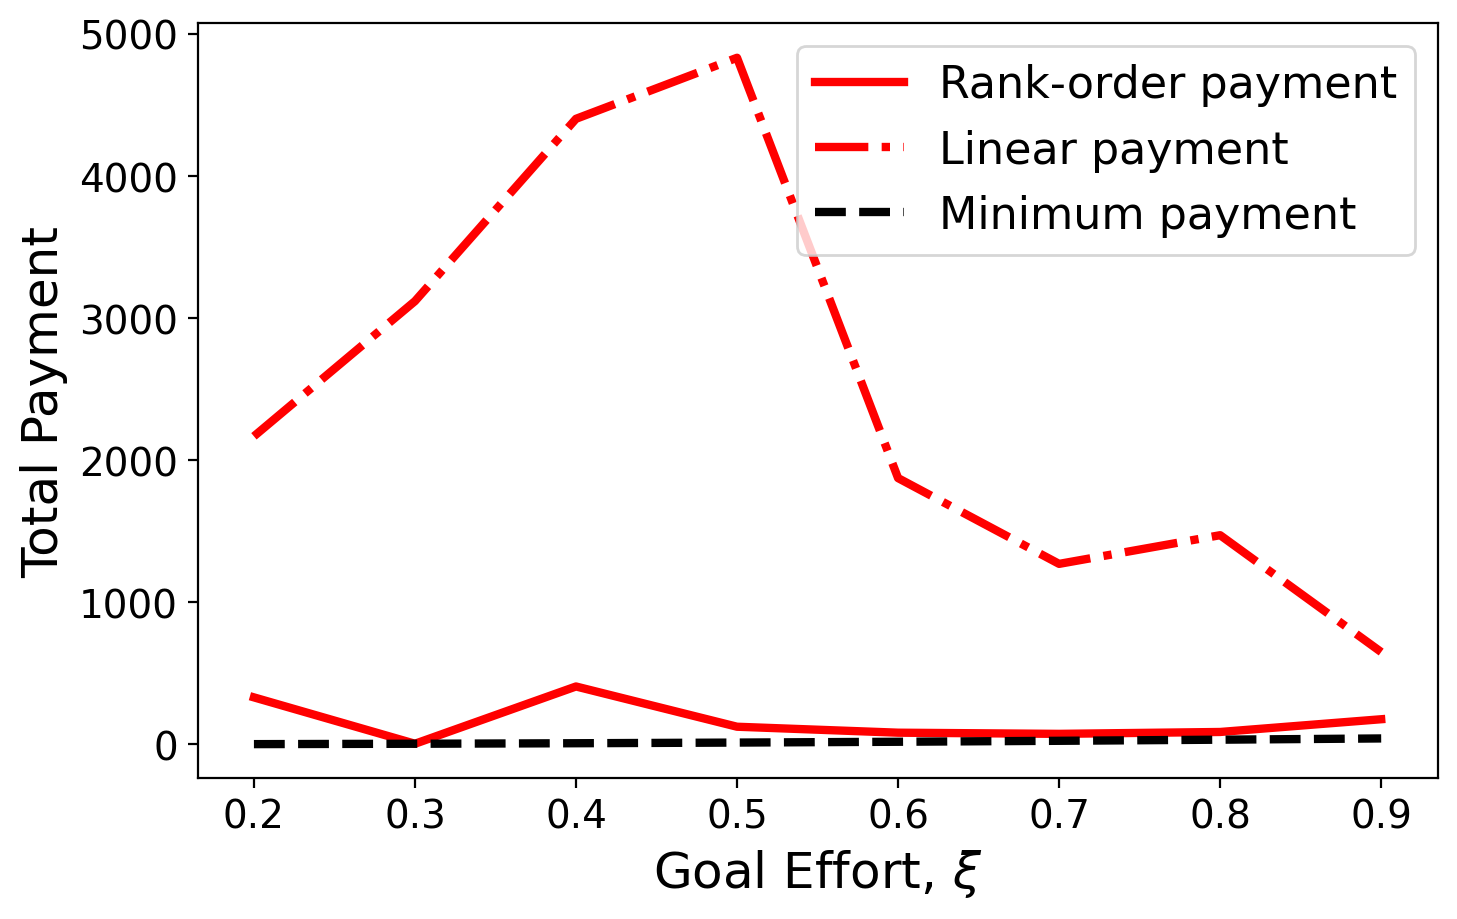

In [314]:
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.
Mechanisms = ['tvd', 'kl', 'sqr', 'hlg']

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)

########## Loading the estimated mean and std
"""
Choose the f function: 1 -> TVD, 2 -> KL, 3 -> Sqr, 4 -> Hlg
"""
f = 3
mean_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean.npy')
std_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance.npy')
mean_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_deviate.npy')
std_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance_deviate.npy')

########## Compute (and smoothen) the probability of ranking after deviation
p_i = np.zeros(len(Effort_list))
for i in range(0,40,5):
    if common_shock[int(i/5)] != -1:
        p_i[int(i/5)] = prob_i(mean_1[i+10], mean_2[i+10], np.sqrt(np.square(std_1[i+10])+np.square(common_shock[int(i/5)])), np.sqrt(np.square(std_2[i+10])+np.square(common_shock[int(i/5)])), 1)
    else:
        p_i[int(i/5)] = prob_i(mean_1[i+10], mean_2[i+10], std_1[i+10], std_2[i+10], 1)
para = np.polyfit(Effort_list, p_i, 3)
p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'red',linewidth = 3,label='Rank-order payment')


    
########## Compute the payment of the optimal linear payment function
Effort_list_2 = np.arange(0,0.97,0.02)
    
sample = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_samples.npy')
mean_1 = np.average(sample[0], axis = 1)
mean_2 = np.average(sample[1], axis = 1)
para = np.polyfit(Effort_list_2, mean_2-mean_1, 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[0,10:48:5].T, axis = 0)
payment = (np.average(sample[0,10:48:5], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(np.array(Effort_list)[index_IR])*n
plt.plot(Effort_list,payment,color = 'red',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list,c,color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)


The $f$-matrix mechanism

In [315]:
"""
Compute the common shock
"""
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 3000 # the number of times the simulation is run
check_prob = 0.2

########## Loading the samples
Mechanisms = ['tvd', 'kl', 'sqr', 'hlg']
f = 3
mean_t = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_larger.npy')
mean_u = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_deviate_larger.npy')
std_t = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_std_larger.npy')
std_u = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_std_deviate_larger.npy')
########## Compute the common shock (winner-take-all)
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

common_shock = np.zeros(8)
for i,e in enumerate(Effort_list): # for each effort
    shock_strategy = []
    for s in range(7): # for each untruthful strategy
        shock_strategy.append(find_minimum_shock_WTA(mean_t[i], mean_u[i,s], std_t[i], std_u[i,s]))
    common_shock[i] = np.max(shock_strategy)
    
print('The minimum common shock for each effort: \n', common_shock)
print('The standard deviation of the original performance score: \n',  std_t)

The minimum common shock for each effort: 
 [-1. -1. -1. -1.  0.  0.  0.  0.]
The standard deviation of the original performance score: 
 [0.0040663  0.0043587  0.00485288 0.00586092 0.00713256 0.00932246
 0.01199306 0.01555969]


Text(0, 0.5, 'Total Payment')

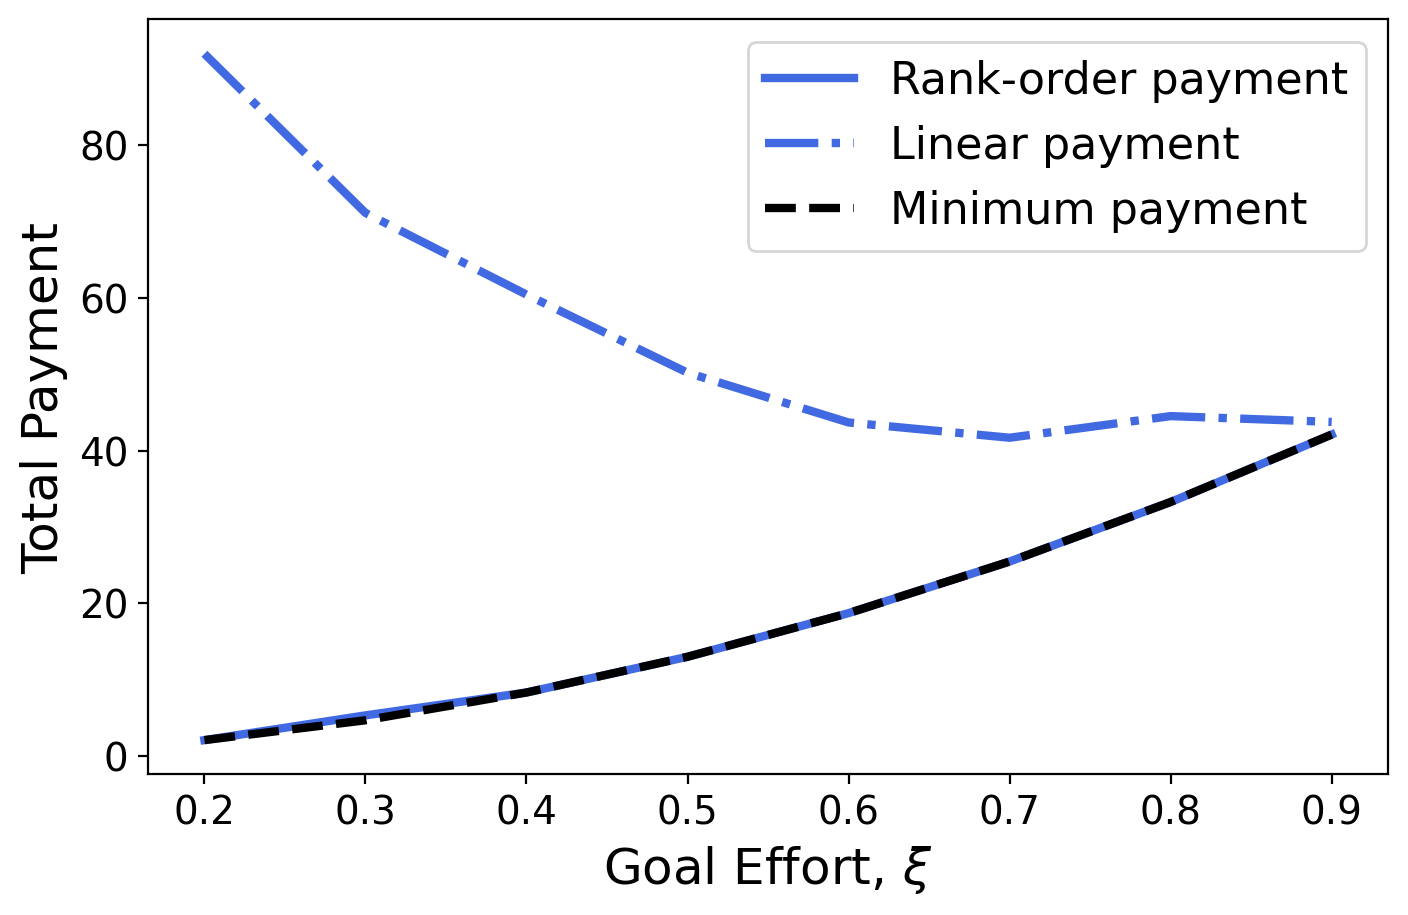

In [316]:
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.
Mechanisms = ['tvd', 'kl', 'sqr', 'hlg']

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)

########## Loading the estimated mean and std
"""
Choose the f function: 1 -> TVD, 2 -> KL, 3 -> Sqr, 4 -> Hlg
"""
f = 3
mean_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean.npy')
std_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance.npy')
mean_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_mean_deviate.npy')
std_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_variance_deviate.npy')

########## Compute (and smoothen) the probability of ranking after deviation
p_i = np.zeros(len(Effort_list))
for i in range(0,40,5):
    if common_shock[int(i/5)] != -1:
        p_i[int(i/5)] = prob_i(mean_1[i+10], mean_2[i+10], np.sqrt(np.square(std_1[i+10])+np.square(common_shock[int(i/5)])), np.sqrt(np.square(std_2[i+10])+np.square(common_shock[int(i/5)])), 1)
    else:
        p_i[int(i/5)] = prob_i(mean_1[i+10], mean_2[i+10], std_1[i+10], std_2[i+10], 1)
para = np.polyfit(Effort_list, p_i, 3)
p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'royalblue',linewidth = 3,label='Rank-order payment')


    
########## Compute the payment of the optimal linear payment function
Effort_list_2 = np.arange(0,0.97,0.02)
    
sample = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_MMI/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mechanism_'+Mechanisms[f]+'_samples.npy')
mean_1 = np.average(sample[0], axis = 1)
mean_2 = np.average(sample[1], axis = 1)
para = np.polyfit(Effort_list_2, mean_2-mean_1, 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[0,10:48:5].T, axis = 0)
payment = (np.average(sample[0,10:48:5], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(np.array(Effort_list)[index_IR])*n
plt.plot(Effort_list,payment,color = 'royalblue',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list,c,color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)


Peer Truth Serum

In [317]:
"""
Compute the common shock
"""
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 3000 # the number of times the simulation is run
check_prob = 0.2

########## Loading the samples
mean_t = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mean_larger.npy')
mean_u = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mean_deviate_larger.npy')
std_t = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_std_larger.npy')
std_u = np.load('Samples/Truthfulness_robustness/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_std_deviate_larger.npy')
########## Compute the common shock (winner-take-all)
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

common_shock = np.zeros(8)
for i,e in enumerate(Effort_list): # for each effort
    shock_strategy = []
    for s in range(7): # for each untruthful strategy
        shock_strategy.append(find_minimum_shock_WTA(mean_t[i], mean_u[i,s], std_t[i], std_u[i,s]))
    common_shock[i] = np.max(shock_strategy)
    
print('The minimum common shock for each effort: \n', common_shock)
print('The standard deviation of the original performance score: \n',  std_t)

The minimum common shock for each effort: 
 [0.         0.         0.01303567 0.         0.12372759 0.14778411
 0.0671617  0.19014206]
The standard deviation of the original performance score: 
 [0.09795745 0.10025227 0.10122102 0.10660065 0.10828807 0.11158041
 0.11558585 0.11940542]


Text(0, 0.5, 'Total Payment')

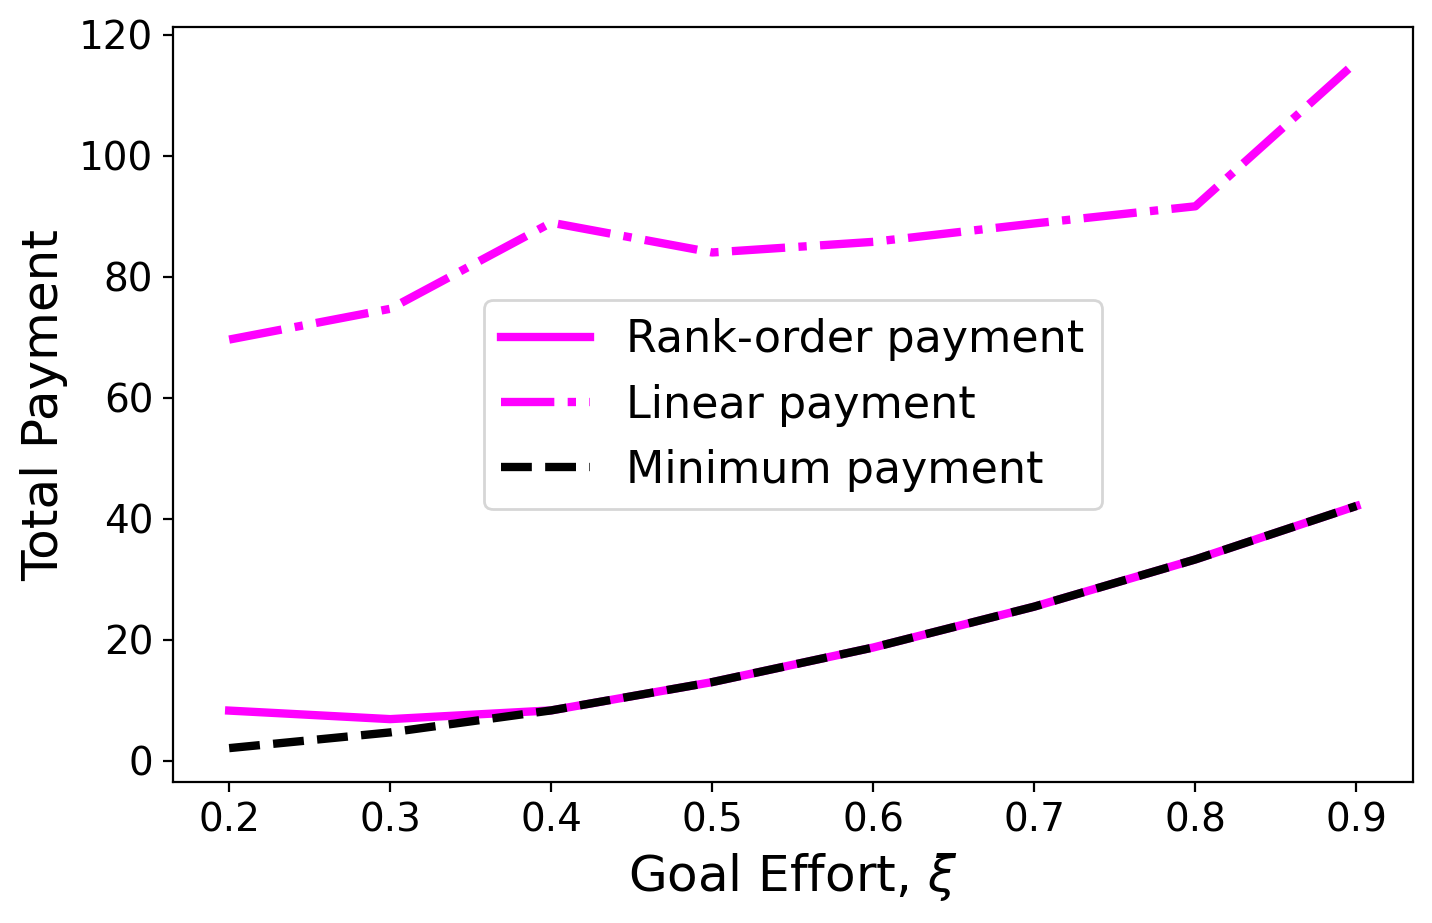

In [319]:
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.
Mechanisms = ['tvd', 'kl', 'sqr', 'hlg']

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)

########## Loading the estimated mean and std
"""
Choose the f function: 1 -> TVD, 2 -> KL, 3 -> Sqr, 4 -> Hlg
"""
mean_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mean.npy')
std_1 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_variance.npy')
mean_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_mean_deviate.npy')
std_2 = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_variance_deviate.npy')

########## Compute (and smoothen) the probability of ranking after deviation
p_i = np.zeros(len(Effort_list))
for i in range(0,40,5):
    if common_shock[int(i/5)] != -1:
        p_i[int(i/5)] = prob_i(mean_1[i+10], mean_2[i+10], np.sqrt(np.square(std_1[i+10])+np.square(common_shock[int(i/5)])), np.sqrt(np.square(std_2[i+10])+np.square(common_shock[int(i/5)])), 1)
    else:
        p_i[int(i/5)] = prob_i(mean_1[i+10], mean_2[i+10], std_1[i+10], std_2[i+10], 1)
para = np.polyfit(Effort_list, p_i, 3)
p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'magenta',linewidth = 3,label='Rank-order payment')


    
########## Compute the payment of the optimal linear payment function
Effort_list_2 = np.arange(0,0.97,0.02)
    
sample = np.load('Samples/Effort_equilibrium/W1/Peer_prediction_PTS/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_samples.npy')
mean_1 = np.average(sample[0], axis = 1)
mean_2 = np.average(sample[1], axis = 1)
para = np.polyfit(Effort_list_2, mean_2-mean_1, 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[0,10:48:5].T, axis = 0)
payment = (np.average(sample[0,10:48:5], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(np.array(Effort_list)[index_IR])*n
plt.plot(Effort_list,payment,color = 'magenta',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list,c,color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)


Spot-checking with accuracy score

In [298]:
"""
Compute the common shock
"""
n = 52 # the number of agents
n0 = 5 # the (minimum) number of agents attached to each task
m = 1000 # the number of tasks
mi = 100 # the number of tasks answered by each agent
T = 100 # the number of times the simulation is run
check_prob = 0.2

########## Loading the samples
sample_truthful = np.load('Samples/Truthfulness_robustness/W1/Spot_checking_Acc/strategic_m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_check_p_'+str(check_prob)+'_samples_larger.npy')
sample_untruthful = np.load('Samples/Truthfulness_robustness/W1/Spot_checking_Acc/strategic_m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_check_p_'+str(check_prob)+'_samples_deviate_larger.npy')

########## Compute the common shock (winner-take-all)
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mean_t = np.mean(sample_truthful, axis = 1)
std_t = np.std(sample_truthful, axis = 1)
mean_u = np.mean(sample_untruthful, axis = 2)
std_u = np.std(sample_untruthful, axis = 2)

common_shock = np.zeros(8)
for i,e in enumerate(Effort_list): # for each effort
    shock_strategy = []
    for s in range(7): # for each untruthful strategy
        shock_strategy.append(find_minimum_shock_WTA(mean_t[i], mean_u[i,s], std_t[i], std_u[i,s]))
    common_shock[i] = np.max(shock_strategy)

print('The minimum common shock for each effort: \n', common_shock)
print('The standard deviation of the original performance score: \n',  std_t)

The minimum common shock for each effort: 
 [0.         0.         0.0869503  0.         0.27535807 0.15913463
 0.15324315 0.        ]
The standard deviation of the original performance score: 
 [0.12212042 0.12112112 0.11921286 0.11841134 0.1168471  0.11390396
 0.11041054 0.11068334]


Text(0, 0.5, 'Total Payment')

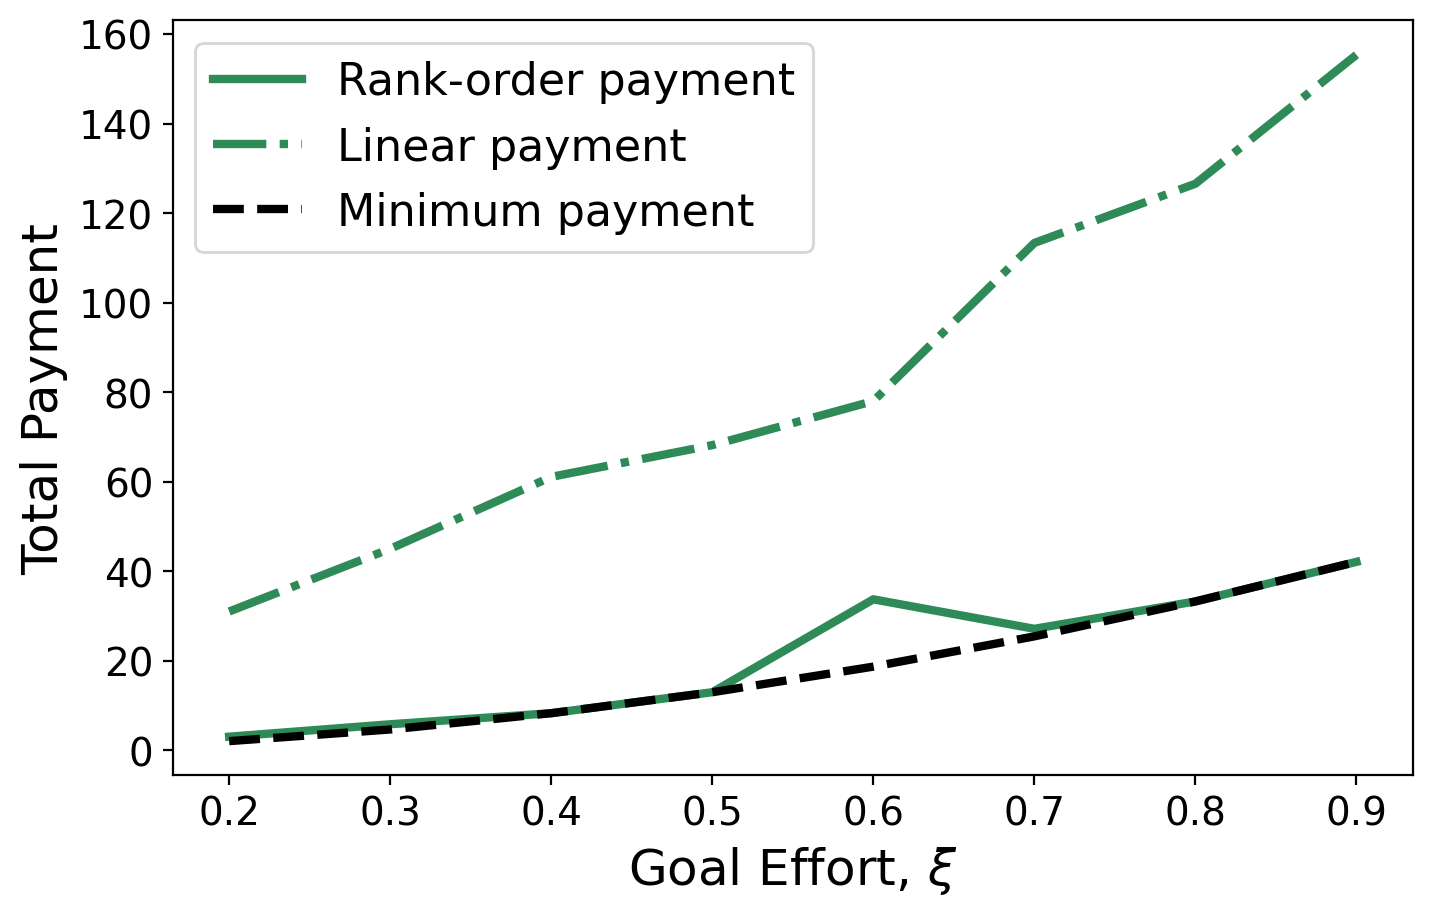

In [299]:
Effort_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # when the effort is low, the variance is greatly increased. With limited time, the number of samples is not large enough to estimate things when effort is low. So \xi<0.2 are dropped.

def cost(e):
    """
    Input: "e" is an agent's effort;
    Output: cost of effort
    """
    return np.power(e,2)

dc = np.zeros(len(Effort_list)) # the "derivative" of the cost function, used to compute the optimal RO-payment function
for j,xi in enumerate(Effort_list):
    dc[j] = cost(xi+0.04) - cost(xi)

def Fitted_function(x, para):
    return para[0]*np.power(x,3)+para[1]*np.power(x,2)+para[2]*np.power(x,1)+para[3]

def prob_i(mu_1, mu_2, sig_1, sig_2, i):
    """
    Input: "mu_1"/"mu_2" is the mean of Gaussian before/after the unilateral deviation;
           "sig_1"/"sig_2" is the std of Gaussian before/after the unilateral deviation;
           "i" is the ranking.
    Output: the probability of an agent being ranked at the i'th place after deviation.
    """
    return integrate.quad(lambda x: norm.pdf(x, mu_2, sig_2)*np.power(norm.cdf(x, mu_1, sig_1), n-i)*np.power(1 - norm.cdf(x, mu_1, sig_1), i-1)*comb(n-1,i-1), -np.inf, np.inf)[0]

plt.figure(figsize=(8,5), dpi= 200)
########## Loading the samples
sample = np.load('Samples/Effort_equilibrium/W1/Spot_check_Acc/m'+str(m)+'_mi'+str(mi)+'_n0'+str(n0)+'_T'+str(T)+'_check_p_'+str(check_prob)+'_samples.npy')

########## Compute (and smoothen) the probability of ranking after deviation
mean = np.average(sample, axis = 1)
std = np.std(sample, axis = 1)

p_i = np.zeros(len(Effort_list))
for i in range(0,40,5):
    p_i[int(i/5)] = prob_i(mean[i+10], mean[i+12], np.sqrt(np.square(std[i+10])+np.square(common_shock[int(i/5)])), np.sqrt(np.square(std[i+12])+np.square(common_shock[int(i/5)])), 1)
    
# para = np.polyfit(Effort_list, p_i, 3)
# p_i = Fitted_function(Effort_list, para) 
dp = p_i-1/n

########## Compute the payment of the optimal RO-payment function (winner-take-all)
t1 = dc/dp
c = cost(Effort_list)*n
payment_ro = np.maximum(t1, c)
plt.plot(Effort_list,payment_ro,color = 'seagreen',linewidth = 3,label='Rank-order payment')



########## Compute the payment of the optimal linear payment function
Effort_list_2 = np.arange(0.2,0.95,0.02)
para = np.polyfit(Effort_list_2, mean[12:50]-mean[10:48], 3)
mean_diff = Fitted_function(Effort_list, para)
a = dc/mean_diff
b = -np.min(a*sample[10:48:5].T, axis = 0)
payment = (np.average(sample[10:48:5], axis = 1)*a+b)*n

index_IR = np.where(payment<cost(Effort_list)*n)
payment[index_IR] = cost(np.array(Effort_list)[index_IR])*n
plt.plot(Effort_list,payment,color = 'seagreen',linestyle = '-.', linewidth = 3,label='Linear payment')

plt.plot(Effort_list,c,color = 'black',linestyle = '--',linewidth = 3,label='Minimum payment')

plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel(r'Goal Effort, $\xi$', fontsize = 18)
plt.ylabel(r'Total Payment', fontsize = 18)
